# Stable Diffusion 3 in KerasHub!

**Author:** [Hongyu Chiu](https://github.com/james77777778), [fchollet](https://twitter.com/fchollet), [lukewood](https://twitter.com/luke_wood_ml), [divamgupta](https://github.com/divamgupta)<br>
**Date created:** 2024/10/09<br>
**Last modified:** 2024/10/24<br>
**Description:** Image generation using KerasHub's Stable Diffusion 3 model.

# Instruction for Your Week 2 Assignment
Run each cell in order until you reach the section labeled "Change Prompt Here."

## Overview

Stable Diffusion 3 is a powerful, open-source latent diffusion model (LDM)
designed to generate high-quality novel images based on text prompts. Released
by [Stability AI](https://stability.ai/), it was pre-trained on 1 billion
images and fine-tuned on 33 million high-quality aesthetic and preference images
, resulting in a greatly improved performance compared to previous version of
Stable Diffusion models.

In this guide, we will explore KerasHub's implementation of the
[Stable Diffusion 3 Medium](https://huggingface.co/stabilityai/stable-diffusion-3-medium)
including text-to-image, image-to-image and inpaint tasks.

To get started, let's install a few dependencies and get images for our demo:

In [1]:
!pip install -Uq keras
!pip install -Uq git+https://github.com/keras-team/keras-hub.git
!wget -O mountain_dog.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
!wget -O mountain_dog_mask.png https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog_mask.png

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.20.0.dev0 which is incompatible.
--2025-03-23 02:31:57--  https://raw.githubusercontent.com/keras-team/keras-io/master/guides/img/stable_diffusion_3_in_keras_hub/mountain_dog.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1187310 (1.1M) [image/png]
Saving to: ‘mountain_dog.png’

mountain_dog.png    100%[=

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import time

import keras
import keras_hub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Introduction

Before diving into how latent diffusion models work, let's start by generating
some images using KerasHub's APIs.

To avoid reinitializing variables for different tasks, we'll instantiate and
load the trained `backbone` and `preprocessor` using KerasHub's `from_preset`
factory method. If you only want to perform one task at a time, you can use a
simpler API like this:

```python
text_to_image = keras_hub.models.StableDiffusion3TextToImage.from_preset(
    "stable_diffusion_3_medium", dtype="float16"
)
```

That will automatically load and configure trained `backbone` and `preprocessor`
for you.

Note that in this guide, we'll use `image_shape=(512, 512, 3)` for faster
image generation. For higher-quality output, it's recommended to use the default
size of `1024`. Since the entire backbone has about 3 billion parameters, which
can be challenging to fit into a consumer-level GPU, we set `dtype="float16"` to
reduce the usage of GPU memory -- the officially released weights are also in
float16.

It is also worth noting that the preset "stable_diffusion_3_medium" excludes the
T5XXL text encoder, as it requires significantly more GPU memory. The performace
degradation is negligible in most cases. The weights, including T5XXL, will be
available on KerasHub soon.

In [3]:

def display_generated_images(images):
    """Helper function to display the images from the inputs.

    This function accepts the following input formats:
    - 3D numpy array.
    - 4D numpy array: concatenated horizontally.
    - List of 3D numpy arrays: concatenated horizontally.
    """
    display_image = None
    if isinstance(images, np.ndarray):
        if images.ndim == 3:
            display_image = Image.fromarray(images)
        elif images.ndim == 4:
            concated_images = np.concatenate(list(images), axis=1)
            display_image = Image.fromarray(concated_images)
    elif isinstance(images, list):
        concated_images = np.concatenate(images, axis=1)
        display_image = Image.fromarray(concated_images)

    if display_image is None:
        raise ValueError("Unsupported input format.")

    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(display_image)
    plt.show()
    plt.close()


backbone = keras_hub.models.StableDiffusion3Backbone.from_preset(
    "stable_diffusion_3_medium", image_shape=(512, 512, 3), dtype="float16"
)
preprocessor = keras_hub.models.StableDiffusion3TextToImagePreprocessor.from_preset(
    "stable_diffusion_3_medium"
)
text_to_image = keras_hub.models.StableDiffusion3TextToImage(backbone, preprocessor)

100%|██████████| 3.12k/3.12k [00:00<00:00, 5.47MB/s]


100%|██████████| 5.57G/5.57G [06:06<00:00, 16.3MB/s]


100%|██████████| 4.08k/4.08k [00:00<00:00, 6.23MB/s]


100%|██████████| 976k/976k [00:01<00:00, 721kB/s]


100%|██████████| 512k/512k [00:01<00:00, 468kB/s]


100%|██████████| 976k/976k [00:01<00:00, 734kB/s]


100%|██████████| 512k/512k [00:01<00:00, 465kB/s]


Next, we give it a prompt:

# 🔄 Change Prompt Here
# This is where you need to change the prompt.
Please replace the text inside the quotation marks in the next line of code with your desired description (for example, “A real house at night time, detailed, 8K”) to generate building or infrastructure images.

In [4]:
prompt = "A real house in night time, detailed, 8k"

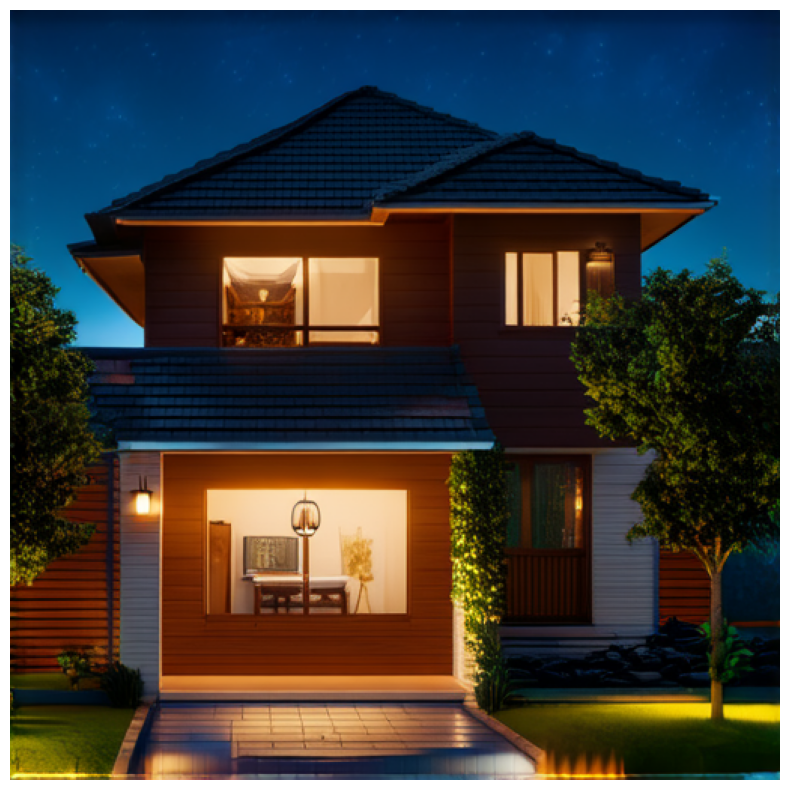

In [5]:
# When using JAX or TensorFlow backends, you might experience a significant
# compilation time during the first `generate()` call. The subsequent
# `generate()` call speedup highlights the power of JIT compilation and caching
# in frameworks like JAX and TensorFlow, making them well-suited for
# high-performance deep learning tasks like image generation.
generated_image = text_to_image.generate(prompt)
display_generated_images(generated_image)


Pretty impressive! But how does this work?

Let's dig into what "latent diffusion model" means.

Consider the concept of "super-resolution," where a deep learning model
"denoises" an input image, turning it into a higher-resolution version. The
model uses its training data distribution to hallucinate the visual details that
are most likely given the input. To learn more about super-resolution, you can
check out the following Keras.io tutorials:

- [Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/)
- [Enhanced Deep Residual Networks for single-image super-resolution](https://keras.io/examples/vision/edsr/)

![Super-resolution](https://i.imgur.com/M0XdqOo.png)

When we push this idea to the limit, we may start asking -- what if we just run
such a model on pure noise? The model would then "denoise the noise" and start
hallucinating a brand new image. By repeating the process multiple times, we
can get turn a small patch of noise into an increasingly clear and
high-resolution artificial picture.

This is the key idea of latent diffusion, proposed in
[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).
To understand diffusion in depth, you can check the Keras.io tutorial
[Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/).

![Denoising diffusion](https://i.imgur.com/FSCKtZq.gif)

To transition from latent diffusion to a text-to-image system, one key feature
must be added: the ability to control the generated visual content using prompt
keywords. In Stable Diffusion 3, the text encoders from the CLIP and T5XXL
models are used to obtain text embeddings, which are then fed into the diffusion
model to condition the diffusion process. This approach is based on the concept
of "classifier-free guidance", proposed in
[Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).

When we combine these ideas, we get a high-level overview of the architecture of
Stable Diffusion 3:

- Text encoders: Convert the text prompt into text embeddings.
- Diffusion model: Repeatedly "denoises" a smaller latent image patch.
- Decoder: Transforms the final latent patch into a higher-resolution image.

First, the text prompt is projected into the latent space by multiple text
encoders, which are pretrained and frozen language models. Next, the text
embeddings, along with a randomly generated noise patch (typically from a
Gaussian distribution), are then fed into the diffusion model. The diffusion
model repeatly "denoises" the noise patch over a series of steps (the more
steps, the clearer and more refined the image becomes -- the default value is
28 steps). Finally, the latent patch is passed through the decoder from the VAE
model to render the image in high resolution.

The overview of the Stable Diffusion 3 architecture:
![The Stable Diffusion 3 architecture](https://i.imgur.com/D9y0fWF.png)

This relatively simple system starts looking like magic once we train on
billions of pictures and their captions. As Feynman said about the universe:
_"It's not complicated, it's just a lot of it!"_

## Text-to-image task

Now we know the basis of the Stable Diffusion 3 and the text-to-image task.
Let's explore further using KerasHub APIs.

To use KerasHub's APIs for efficient batch processing, we can provide the model
with a list of prompts:

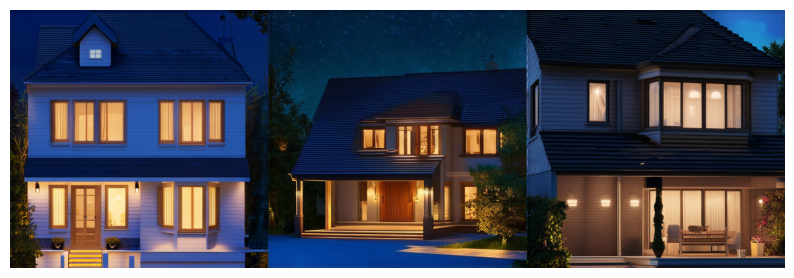

In [6]:
generated_images = text_to_image.generate([prompt] * 3)
display_generated_images(generated_images)

The `num_steps` parameter controls the number of denoising steps used during
image generation. Increasing the number of steps typically leads to higher
quality images at the expense of increased generation time. In
Stable Diffusion 3, this parameter defaults to `28`.

In [ ]:
num_steps = [10, 28, 50]
generated_images = []
for n in num_steps:
    st = time.time()
    generated_images.append(text_to_image.generate(prompt, num_steps=n))
    print(f"Cost time (`num_steps={n}`): {time.time() - st:.2f}s")

display_generated_images(generated_images)

Cost time (`num_steps=10`): 4.04s
Cost time (`num_steps=28`): 10.66s


We can use `"negative_prompts"` to guide the model away from generating specific
styles and elements. The input format becomes a dict with the keys `"prompts"`
and `"negative_prompts"`.

If `"negative_prompts"` is not provided, it will be interpreted as an
unconditioned prompt with the default value of `""`.

# 🔄 Change Prompt Here
# This is where you need to change the prompt.
Please replace the text inside the quotation marks for the value of "negative_prompts"in the next line of code with your desired description (for example, “Bright”) to generate building or infrastructure images.

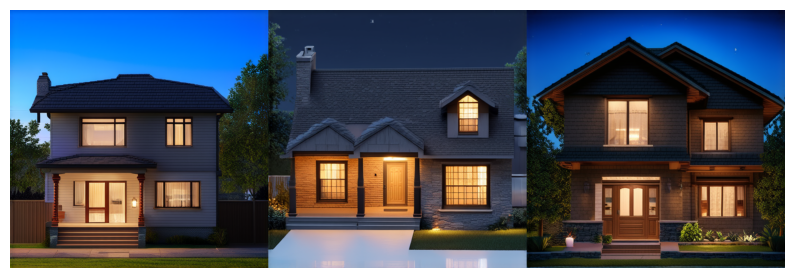

In [7]:
generated_images = text_to_image.generate(
    {
        "prompts": [prompt] * 3,
        "negative_prompts": ["Bright"] * 3,
    }
)
display_generated_images(generated_images)

`guidance_scale` affects how much the `"prompts"` influences image generation.
A lower value gives the model creativity to generate images that are more
loosely related to the prompt. Higher values push the model to follow the prompt
more closely. If this value is too high, you may observe some artifacts in the
generated image. In Stable Diffusion 3, it defaults to `7.0`.

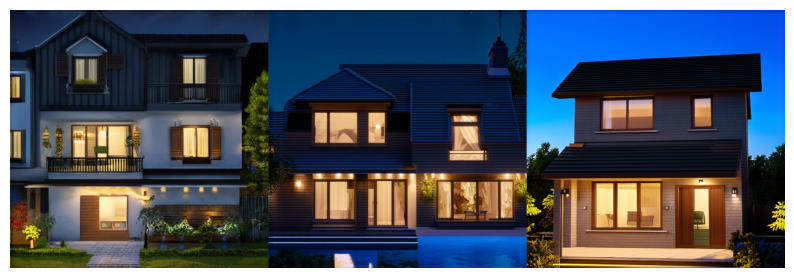

In [9]:
generated_images = [
    text_to_image.generate(prompt, guidance_scale=2.5),
    text_to_image.generate(prompt, guidance_scale=7.0),
    text_to_image.generate(prompt, guidance_scale=10.5),
]
display_generated_images(generated_images)

Note that `negative_prompts` and `guidance_scale` are related. The formula in
the implementation can be represented as follows:
`predicted_noise = negative_noise + guidance_scale * (positive_noise - negative_noise)`.

## Conclusion

KerasHub's `StableDiffusion3` supports a variety of applications and, with the
help of Keras 3, enables running the model on TensorFlow, JAX, and PyTorch!